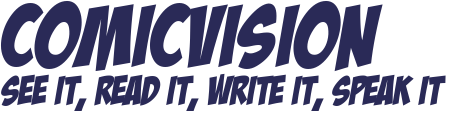

Text(0.5, 1.0, ' Comic Vision (Spanish -> English) "Mafalda" ')

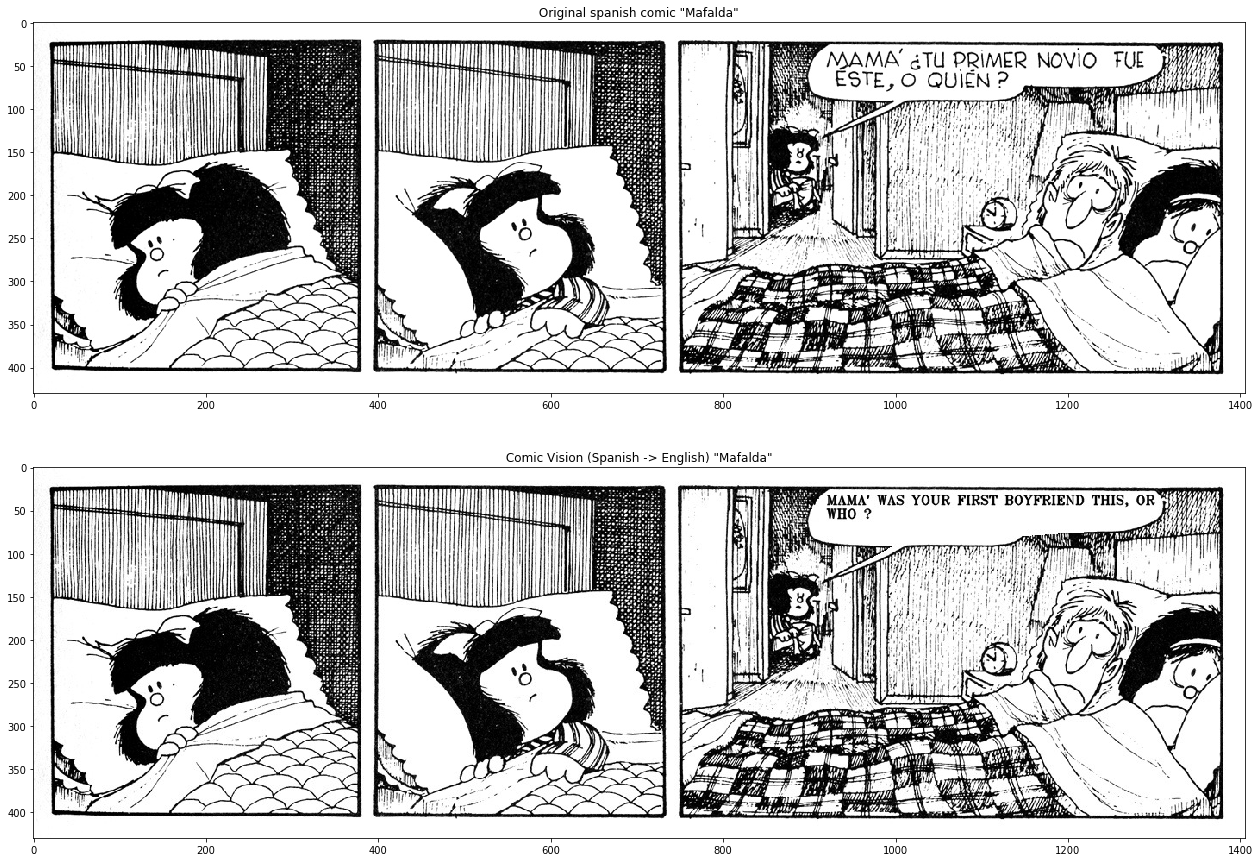

In [1167]:
%matplotlib inline

import cv2
import itertools
from io import BytesIO
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os
from PIL import Image
import random
import requests
import uuid

######### SAMPLE IMAGE OF COMIC VISION

fig, axes = plt.subplots(nrows=2, figsize=(30,15))
axes[0].imshow(spanish)
axes[0].set_title(' Original spanish comic "Mafalda" ')
axes[1].imshow(spanish_to_english)
axes[1].set_title(' Comic Vision (Spanish -> English) "Mafalda" ')

In [1151]:
######### UTILITIES

# Microsoft Azure translation parameter dictionary

translation_codes = {
    'ChineseSimplified' : 'zh-Hans',
    'ChineseTraditional' : 'zh-Hant', 
    'Czech' : 'cs',
    'Danish' : 'da', 
    'Dutch' : 'nl',
    'English' : 'en',
    'Finnish' : 'fi', 
    'French' : 'fr',
    'German' : 'de', 
    'Greek' : 'el',
    'Hungarian' : 'hu', 
    'Italian' : 'it',
    'Japanese' : 'ja', 
    'Korean' : 'ko',
    'Norwegian' : 'nb', 
    'Polish' : 'pl',
    'Portuguese' : 'pt', 
    'Russian' : 'ru',
    'Spanish' : 'es',
    'Swedish' : 'sv',
    'Turkish' : 'tr', 
    'Arabic' : 'ar',
    'Romanian' : 'ro',
    'SerbianCyrillic' : 'sr-Cyrl', 
    'SerbianLatin' : 'sr-Latn', 
    'Slovak' : 'sk', 
    'Unknown' : 'unk'}


def calculate_iom(bb1, bb2):
    """
    Calculate the intersection over minimum to determine containment
    
    PARAMETERS
    ----------
    bb1, bb2 : dictionaries of box coordinates (x1, y1) top left corner, (x2, y2) bottom right corner
               {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2}
               
    RETURN
    ------
    Tuple : ( area of intersection / min area, 0/1 indicator of larger area )
    
    """
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return (0.0, None)
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iom = intersection_area / float(min(bb1_area, bb2_area)+1e-6)
    bigger_area = max(bb1_area, bb2_area)
    bigger_ix = int(bigger_area == bb2_area)
    
    return (iom, bigger_ix)

def getContourStat(contour,image):
    """
    Find mean pixel intensity inside contour
    
    PARAMETERS
    ----------
    contour : list of x,y coordinates approximating speech box/bubble contour
    image : numpy.ndarray with shape (l, w, c)
    
    RETURN
    ------
    mean : float
    
    """
    mask = np.zeros(image.shape,dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    mean,stddev = cv2.meanStdDev(image,mask=mask)
    return mean

def preprocess_for_ocr_v1(img_array):
    # CONVERT TO BLACK AND WHITE
    img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 3)
    
    # THICKEN LINES AND REMOVE NOISE
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((1,1), np.uint8))
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, np.ones((1,1), np.uint8))
    
    _, thres_img = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    ocr_image = cv2.bitwise_or(thres_img, closing)
    
    return ocr_image

    
def preprocess_for_ocr_v2(img_array):
    """
    Preprocess image for the purpose of OCR text detection
    
    PARAMETERS
    ----------
    img_array : numpy.ndarray with shape (l, w, c)
    
    RETURNS
    -------
    img : numpy.ndarray with shape (l, w, c)
    
    """
    img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_LINEAR)
    _, img = cv2.threshold(img, 130, 255, cv2.THRESH_BINARY)
    #_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #img = cv2.erode(img, np.ones((3,3), dtype=np.uint8), iterations = 1)
    #img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 3)
    return img

def maximum_rectangle(image, approx):
    """
    Find the maximum rectangle inscribed in a speech bubble
    
    PARAMETERS
    ----------
    image : numpy.ndarray with shape (l, w, c)
    approx : numpy.ndarray, (x, y) coordinates of speech bubble/box contour
             
    RETURN
    ------
    tuple | None : coordinates of inscribed rectangle
    """
    
    # Generate all possible coordinate pairs for top-left & bottom-right corners
    possible_rect = []
    for i in range(len(approx)):
        x0, y0 = approx[i][0]
        for j in range(len(approx)):
            x1, y1 = approx[j][0]
            area = abs((y1-y0)*(x1-x0))
            possible_rect.append(((x0,y0),(x1,y1),area))

    possible_rect.sort(key = lambda x:x[2], reverse = True)

    if possible_rect:
        # Check to make sure there are no obstructions to forming box
        
        for (x0, y0), (x1, y1), area in possible_rect:
            valid_rect = True
            x_min = min(x0,x1)
            err_x = 0
            while x_min <= max(x0,x1) and valid_rect:
                if image[y0,x_min] == 0 or image[y1,x_min] == 0:
                    err_x += 1
                    if err_x > 20:
                        valid_rect = False
                x_min +=1

            y_min = min(y0,y1)
            err_y = 0
            while y_min <= max(y0,y1) and valid_rect:
                if image[y_min,x0] == 0 or image[y_min,x1] == 0:
                    err_y += 1
                    if err_y > 20:
                        valid_rect = False
                y_min +=1

            if valid_rect:
                return (min(y0, y1), max(y0, y1), min(x0,x1), max(x0,x1)), area


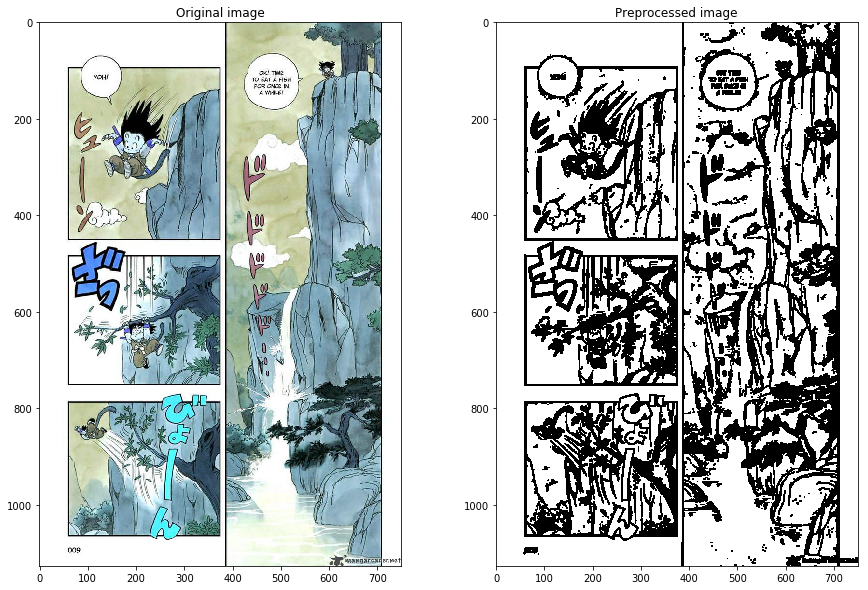

In [1168]:
######### LOAD AND PREPROCESS

image_folder = os.path.join(os.getcwd(), 'dragonball_english')
image_paths = [os.path.join(image_folder, image_name) for image_name in os.listdir(image_folder)]
#original_image = cv2.imread(random.choice(image_paths))
original_image = cv2.imread(image_paths[0])


def preprocess_image(in_image, visualize=False):
    """
    Preprocess image for the purpose of text bubble detection
    
    PARAMETERS
    ----------
    in_image : numpy.ndarray with shape (l, w, c)
    visualize : display original and preprocessed image
    
    RETURN
    ------
    out_image : numpy.ndarray with shape (l, w, c)
    
    """
    
    out_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2GRAY)
    out_image = cv2.adaptiveThreshold(out_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 75, 10)
    out_image = cv2.erode(out_image, np.ones((3,3)), iterations = 1)

    if visualize:
        fig, axes = plt.subplots(ncols=2, figsize=(15,10))
        axes[0].imshow(in_image)
        axes[0].set_title('Original image')
        axes[1].imshow(out_image, cmap='gray')
        axes[1].set_title('Preprocessed image')
    
    return out_image

image = preprocess_image(original_image, visualize=True)

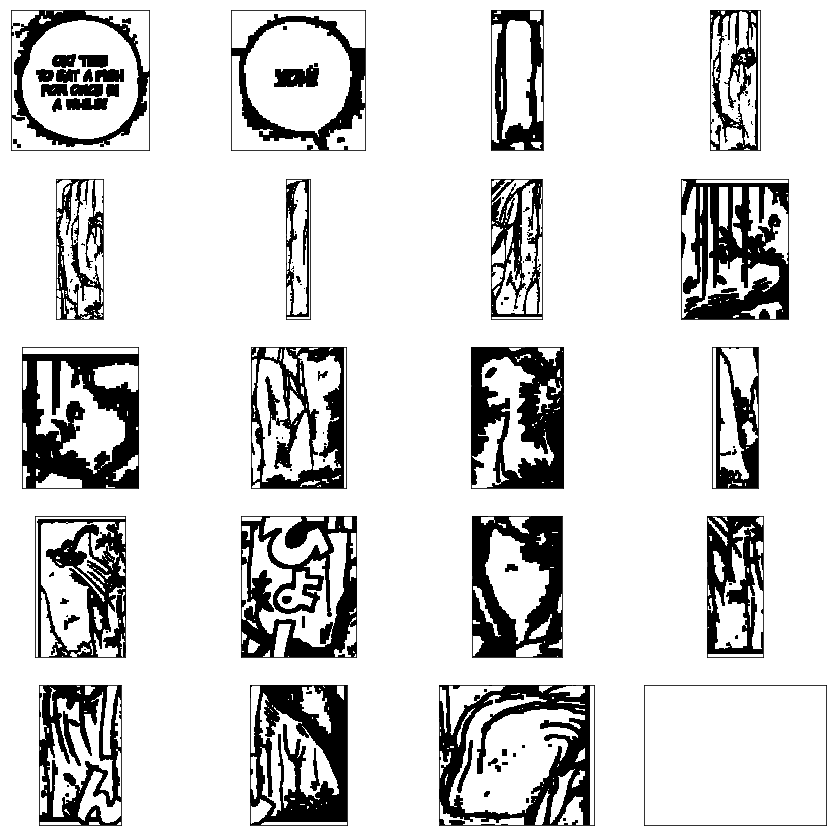

In [1162]:
######### FILTER BUBBLES FIRST PASS

def connected_components(image, iom_threshold=0.7, offset = 10, visualize=False):
    """
    Rough estimation of bounding boxes using connect_components, 
    contains noisy/redundent information, however it always includes 
    all speech bubbles / text boxes among estimates so we use this 
    as a first pass filter
    
    PARAMETERS
    ----------
    image : numpy.ndarray with shape (l, w, c)
    iom_threshold : float, determines % of overlap necessary to discard overlapping bounding boxes
    offset : int, extends bounding boxes to include edges of panels
    
    RETURN
    ------
    box_candidates : list of tuples (y0, y1, x0, x1) denoting bounding box upper-left and bottom-right corners 
    
    """
    box_stats = cv2.connectedComponentsWithStats(image, 4, cv2.CV_32S)[2]
    box_area = box_stats[:, 4]
    
    l, w = image.shape
    area_condition = (box_area > l*w/20**2) & (box_area < l*w/7**2)
    filtered_stats = box_stats[area_condition]
    
    box_candidates = []  
    for x,y,w,h in filtered_stats[:, :4]:
        box_candidates.append((y-offset, y+h+offset, x-offset, x+w+offset))

    if visualize:
        # Messy grid visualization of box_candidates
        nrows, ncols = 5, int(len(box_candidates)/5) + 1
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        ix = 0
        for row in axes:
            for col in row: 
                if ix < len(box_candidates):
                    pts = box_candidates[ix]
                    y0,y1,x0,x1 = pts
                    col.imshow(image[y0:y1,x0:x1], cmap='gray')
                col.get_xaxis().set_ticks([])
                col.get_yaxis().set_ticks([])
                ix += 1
        plt.show()
    
    return box_candidates

box_candidates = connected_components(image, visualize=True)

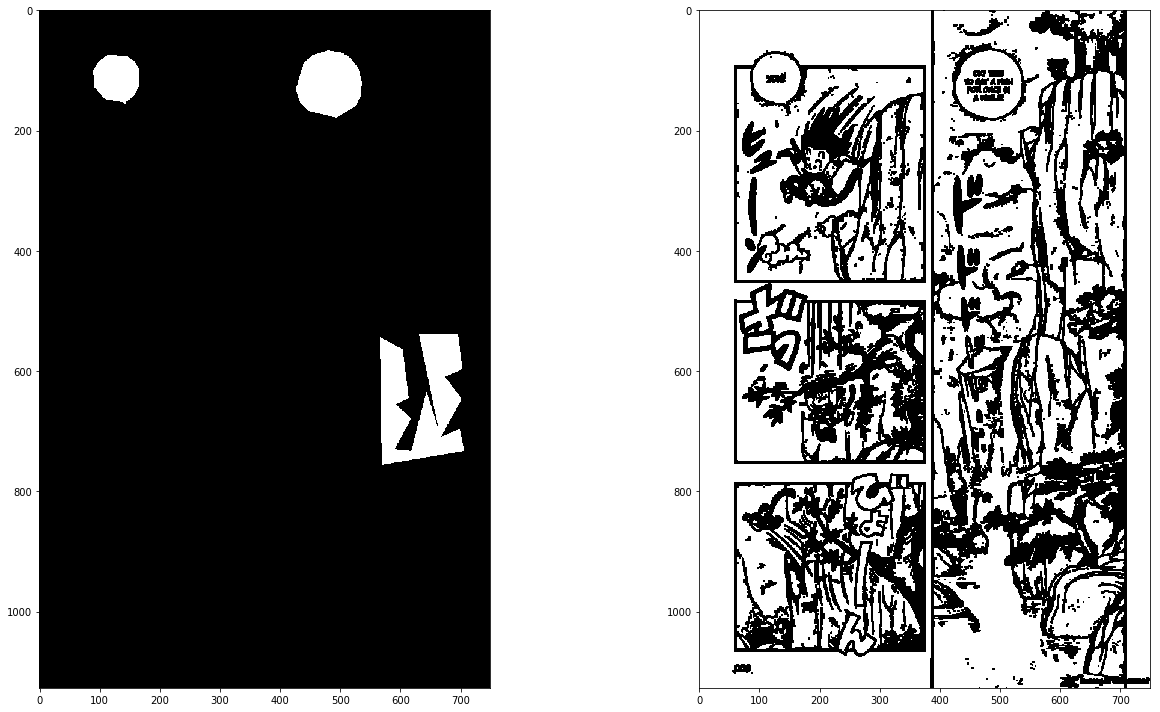

In [1163]:
######### FILTER BUBBLES SECOND PASS

def bubble_contours(image, box_candidates, iom_threshold = 0.5, convexify = False, visualize = False):
    """
    Find contours of bounding boxes in box_candidates, refine boundary estimates & discard redundency
    
    PARAMETERS
    ----------
    image : numpy.ndarray with shape (l, w, c)
    box_candidates : list of tuples, (y0,y1,x0,x1) denoting bounding box upper-left and bottom-right corners 
    iom_threshold : float, determines % of overlap necessary to discard overlapping bounding boxes
    convexify : bool, indicates if contour estimates of speech bubbles should be convex or not
    visualize : bool, display segmentation map and preprocessed image
    
    RETURN
    ------
    box_stats : list of 2-tuples (contour_coordinates, bounding_box_coordinates)
    
    """
    
    draw_mask = np.zeros_like(image)
      
    box_stats = []
    for y0,y1,x0,x1 in box_candidates:
        # Find contours of speech bubbles in connected components (rectangular boxes)
        mask = np.zeros_like(image)
        mask[y0:y1,x0:x1] = image[y0:y1,x0:x1]
        _, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:3]
        for cnt in cnts:
            approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt,True), True)

            # Check pixel intensity and discard those lying outside normal (heuristic) range
            if getContourStat(cnt, image) > 240 or getContourStat(cnt, image) < 100:
                continue
                
            x,y,w,h = cv2.boundingRect(cnt)
            cnt_area = cv2.contourArea(cnt)
            circle_radius = cv2.minEnclosingCircle(cnt)[1]
            circle_area_ratio = int(3.14 * circle_radius**2 / (cnt_area + 1e-6))
            rect_area_ratio = int(w*h/cnt_area)
            # This is a speech "bubble" heuristic, it should also work for boxes
            # The basic idea is that a bubbles area should approximate that of an enclosing circle
            if ((circle_area_ratio <= 2) & (cnt_area > 4000)) or (rect_area_ratio == 1):
                if convexify: 
                    approx = cv2.convexHull(approx)
                box_stats.append((approx, (y,y+h,x,x+w)))
                cv2.fillPoly(draw_mask, [approx], (255,255,255))

                
#    # Remove overlapping boxes
#    coordinates = [pts for _, pts in box_stats]
#    coordinate_pairs = itertools.combinations(coordinates, 2)

#    for bb1, bb2 in coordinate_pairs:
#        dict1 = dict(zip(['y1', 'y2', 'x1', 'x2'], bb1))
#        dict2 = dict(zip(['y1', 'y2', 'x1', 'x2'], bb2))

#        iom, bigger_ix = calculate_iom(dict1, dict2)
#        if iom > iom_threshold:
#            if bigger_ix == 0:
#                smaller = bb2
#            else:
#                smaller = bb1 
#            if smaller in coordinates:
#                smaller_ix = coordinates.index(smaller)
#                del coordinates[smaller_ix]
#                del box_stats[smaller_ix]
    
    if visualize:
        fig, ax = plt.subplots(ncols=2, figsize = (20,10))
        ax[0].imshow(draw_mask, cmap='gray')
        ax[1].imshow(image, cmap='gray')
        plt.tight_layout()
    
    
    return box_stats
    
box_stats = bubble_contours(image, box_candidates, visualize=True)

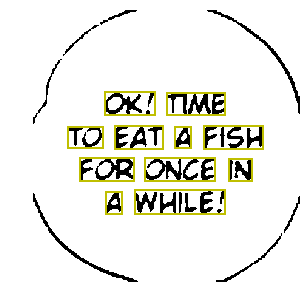

In [1164]:
######### AZURE OCR


OCR_subscription_key = '6b334e1cd4674078bda1e1af077e7354'
OCR_endpoint = 'https://comicvision.cognitiveservices.azure.com/'


def azure_OCR(img_array, language_input = 'English', detectOrientation = 'true', visualize=False):
    
    # Azure parameters
    global OCR_subscription_key
    global OCR_endpoint
    global translation_dict
        
    OCR_url = OCR_endpoint + "vision/v2.0/ocr"
    
    language = translation_codes[language_input]
    OCR_params = {'language': language, 
                  'defaultLanguageCode' : language,
                  'detectOrientation': detectOrientation}
    
    OCR_headers = {'Ocp-Apim-Subscription-Key': OCR_subscription_key, 
               'Content-Type': 'application/octet-stream'}
    

    # Read the image into a byte array
    _, im_buf_arr = cv2.imencode(".jpg", img_array)
    image_data = BytesIO(im_buf_arr).read1(-1)
    
    response = requests.post(OCR_url, headers=OCR_headers, params=OCR_params, data=image_data)
    analysis = response.json()
    # Extract the word bounding boxes and text.
    if 'regions' not in analysis:
        return []
        
    line_infos = [region["lines"] for region in analysis["regions"]]
    word_infos = []
    words = []
    for line in line_infos:
        for word_metadata in line:
            for word_info in word_metadata["words"]:
                word_infos.append(word_info)
    for word_dict in word_infos:
        word = word_dict['text']
        if isinstance(word, str):
            words.append(word)
                    
    # Display the image and overlay it with the extracted text.
    if visualize == True:
        plt.figure(figsize=(5, 5))
        ax = plt.imshow(img_array, cmap='gray')
        for word in word_infos:
            bbox = [int(num) for num in word["boundingBox"].split(",")]
            text = word["text"]
            origin = (bbox[0], bbox[1])
            patch = Rectangle(origin, bbox[2], bbox[3],
                              fill=False, linewidth=2, color='y')
            ax.axes.add_patch(patch)
        plt.axis("off")
    
    return words

approx, (y0, y1, x0, x1) = box_stats[0]
img = original_image[y0:y1, x0:x1]
img = preprocess_for_ocr_v2(img)
ocr_result = azure_OCR(img, visualize=True)
ocr_text = ' '.join(ocr_result)

In [1165]:
######### AZURE TRANSLATION

TRANS_subscription_key = 'b7395ad645fc4d669f52f888efc0793c'
TRANS_endpoint = 'https://api.cognitive.microsofttranslator.com'

def azure_translation(input_text, language_input = 'Unknown', language_output = 'English'):
    """
    Azure translation
    
    PARAMETERS
    ----------
    input_text : str, text of type language_input to be translated
    language_input : str, abbreviation of language type i.e. 'en', 'ja', 'de', ...
                     if '' then azure OCR will detect language
    language_output : str, abbreviation of language type i.e. 'en', 'ja', 'de', ...
    
    RETURNS
    -------
    translated_text : str
    """
    
    global TRANS_subscription_key 
    global TRANS_endpoint 
    global translation_codes
    
    #translate_from = ''
    if language_input == 'Unknown' or language_input == '':
        translate_from = ''
    else:
        language_in = translation_codes[language_input]
        translate_from = '&from=' + language_in
    
    language_out = translation_codes[language_output]
    translate_to = '&to=' + language_out
    translate = translate_from + translate_to
    translation_url = TRANS_endpoint + '/translate?api-version=3.0' + translate

    headers = {
        'Ocp-Apim-Subscription-Key': TRANS_subscription_key,
        'Content-type': 'application/json',
        'X-ClientTraceId': str(uuid.uuid4())
    }

    body = [{
        'text': input_text
    }]

    request = requests.post(translation_url, headers=headers, json=body)
    response = request.json()
    translated_text = response[0]['translations'][0]['text']
    return translated_text

language_out = 'SerbianLatin'
translated_text = azure_translation(ocr_text, language_output = language_out)


print('ORIGINAL TEXT:')
print('-------------')
print(ocr_text)
print('\n \n')
print('TRANSLATED TEXT TO {}:'.format(language_out))
print('-------------')
print(translated_text)
print('-------------')

ORIGINAL TEXT:
-------------
0K! TIME TO EAT A FISH FOR ONCE IN A WHILE!

 

TRANSLATED TEXT TO SerbianLatin:
-------------
0K! VREME JE DA POJEDEMO RIBU PONEKAD!
-------------


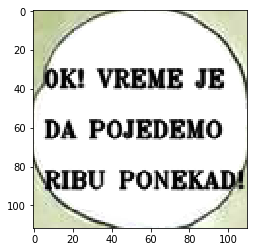

In [1166]:
######### WRITE TEXT INTO BUBBLE

def writeText(image, box_pts, text, visualize = False,
              font=cv2.FONT_HERSHEY_TRIPLEX,
              font_size=0.4,
              font_thickness=1,
              lineType=cv2.LINE_AA):
    
    """
    Write text into rectangle determined by box_pts
    
    PARAMETERS
    ----------
    image: numpy.ndarray with shape (l, w, c)
    box_pts : tuple, (y0, y1, x0, x1) where (x0,y0) is top-left corner and (x1,y1) is bottom right corner of box
    text : str, text string to write into box
             
    RETURN
    ------
    None : write text directly into input image
    """
    
    if len(text) == 0:
        return
    
    y0, y1, x0, x1 = box_pts   
    box_width = x1 - x0
    
    s, e = 0, 0
    ckpt = 0
    line_ix = 3
    
    while e < len(text):
        
        (text_length, text_height), baseline = cv2.getTextSize(text[s:e], font, font_size, font_thickness)
        y_pad = text_height + 4
        x_pad = 5
        
        if text_length <= box_width:
            if text[e] == ' ':
                ckpt = e
            e += 1

        else:
            line = text[s:ckpt]
            cv2.putText(image, line, (x0 + x_pad, y0 + y_pad*line_ix), font,
                        font_size, 
                        (0,0,0), 
                        font_thickness, 
                        lineType)
            line_ix += 2
            s = ckpt + 1
            
    cv2.putText(image, text[s:], (x0 + x_pad, y0 + y_pad*line_ix), font,
                font_size, 
                (0,0,0), 
                font_thickness, 
                lineType)
    
    if visualize:
        plt.imshow(image[y0:y1, x0:x1], cmap='gray')
        plt.show()
        

def rewrite_text_to_fit(text, box_width,
                       font=cv2.FONT_HERSHEY_TRIPLEX,
                       font_size=0.5,
                       font_thickness=1):
    
    """
    Rewrite text such that long words which exceed box boundaries are split with hyphen
    
    PARAMETERS
    ----------
    text : str
    box_width : int, width of box which text is to be inserted into
             
    RETURN
    ------
    str : new text which conforms to box conditions
    
    """
    word_list = text.split(' ')
    updated_list = []
    for word in word_list:
        word_length = cv2.getTextSize(word, font, font_size, font_thickness)[0][0]
        if box_width < word_length:
            i = 0
            while cv2.getTextSize(word[:i]+'-', font, font_size, font_thickness)[0][0] < box_width:
                i +=1
            updated_list.append(word[:i-1]+'-')
            updated_list.append('-'+word[i-1:])
            
        elif cv2.getTextSize(word, font, font_size, font_thickness)[0][0] < box_width:
            updated_list.append(word)
            
    return ' '.join(updated_list)

output_image = original_image[:]
cv2.fillPoly(output_image, [approx], (255,255,255))
writeText(output_image, (y0,y1,x0,x1), translated_text, visualize=True)

-------------
COMIC SCRIPT:
-------------


0K! VREME JE DA POJEDEMO RIBU PONEKAD!
YOH!


-------------
COMIC PAGE TRANSLATED FROM English TO SerbianLatin:
-------------


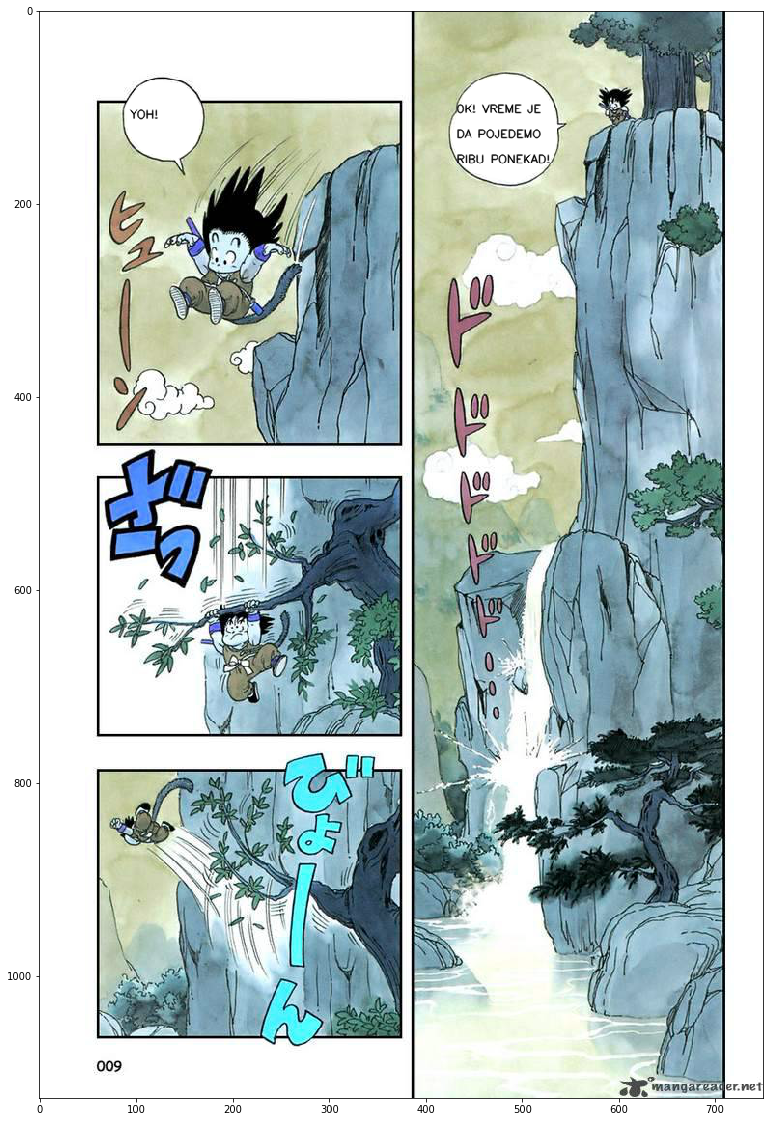

In [1148]:
"""

PUTTING IT ALL TOGETHER

"""

### SET PARAMETERS FOR CONNECTION TO AZURE OCR AND TRANSLATION

# OCR
OCR_subscription_key = '6b334e1cd4674078bda1e1af077e7354'
OCR_endpoint = 'https://comicvision.cognitiveservices.azure.com/'
ocr_url = endpoint + "vision/v2.0/ocr"
OCR_headers = {'Ocp-Apim-Subscription-Key': subscription_key, 
               'Content-Type': 'application/octet-stream'}

# TRANSLATION
TRANS_subscription_key = 'b7395ad645fc4d669f52f888efc0793c'
TRANS_endpoint = 'https://api.cognitive.microsofttranslator.com'

# SPECIFY FOLDER PATH CONTAINING IMAGES
folder_name = 'Dragonball_english'

# SPECIFY INPUT AND OUTPUT LANGUAGE ( language_input = 'Unknown' otherwise)
language_input = "English"
language_output = "SerbianLatin"



### BEGIN PROCESS

# LOAD IMAGE
image_folder = os.path.join(os.getcwd(), folder_name)
image_paths = [os.path.join(image_folder, image_name) for image_name in os.listdir(image_folder)]
#original_image = cv2.imread(random.choice(image_paths))
original_image = cv2.imread(image_paths[0])

image = preprocess_image(original_image)
box_candidates = connected_components(image)
box_stats = bubble_contours(image, box_candidates)

# SET DEFAULT PARAMETERS
font=cv2.FONT_HERSHEY_SIMPLEX
font_size=0.4
font_thickness=1
lineType=cv2.LINE_AA


# COPY ORIGINAL IMAGE AND APPLY CHANGES TO OUTPUT IMAGE

output_image = original_image[:]
output_text = []
for approx, outer_box_pts in box_stats:
    y0,y1,x0,x1 = outer_box_pts
    ocr_box = original_image[y0:y1,x0:x1]
    
    #### THIS NEEDS TO BE IMPLEMENTED ####
    
    #words_list = azure_OCR(preprocess_for_ocr(ocr_box))
    words_list = azure_OCR(preprocess_for_ocr_v2(ocr_box), language_input = language_input)
    if words_list == []:
        continue
            
    text = ' '.join(words_list)
    translated_text = azure_translation(text, language_input = language_input, language_output = language_output)
    # Clear area inside output_image for translated text
    cv2.fillPoly(output_image, [approx], (255,255,255))
    # Clear area inside image to calculate maximum_rectangle without text obstruction
    cv2.fillPoly(image, [approx], (255,255,255))

    outer_box_area = abs((y1-y0)*(x1-x0))
    
    # Check to see if maxmium_rectangle is big enough to replace original approximation
    max_rect = maximum_rectangle(image, approx)
    if max_rect is not None:
        inside_box_pts, inside_box_area = max_rect     
        # If outer_box_area >> inside_box_area we choose to write into outer_box_area
        if int(outer_box_area/inside_box_area) <= 1:
            write_pts = inside_box_pts
        else:
            write_pts = outer_box_pts
    else:
        write_pts = outer_box_pts
    
    y0, y1, x0, x1 = write_pts
    box_width = x1 - x0
    out_text = rewrite_text_to_fit(translated_text, box_width, font, font_size, font_thickness)
    output_text.append(out_text)
    writeText(output_image, write_pts, out_text, visualize=False,
              font=font,
              font_size=font_size,
              font_thickness=font_thickness,
 
              lineType=lineType)

print('-------------')
print('COMIC SCRIPT:')
print('-------------')
print('\n')
print('\n'.join(output_text))
print('\n')
print('-------------')
print('COMIC PAGE TRANSLATED FROM {} TO {}:'.format(language_input, language_output))
print('-------------')

fig, ax = plt.subplots(figsize=(30,20))
ax.imshow(output_image)

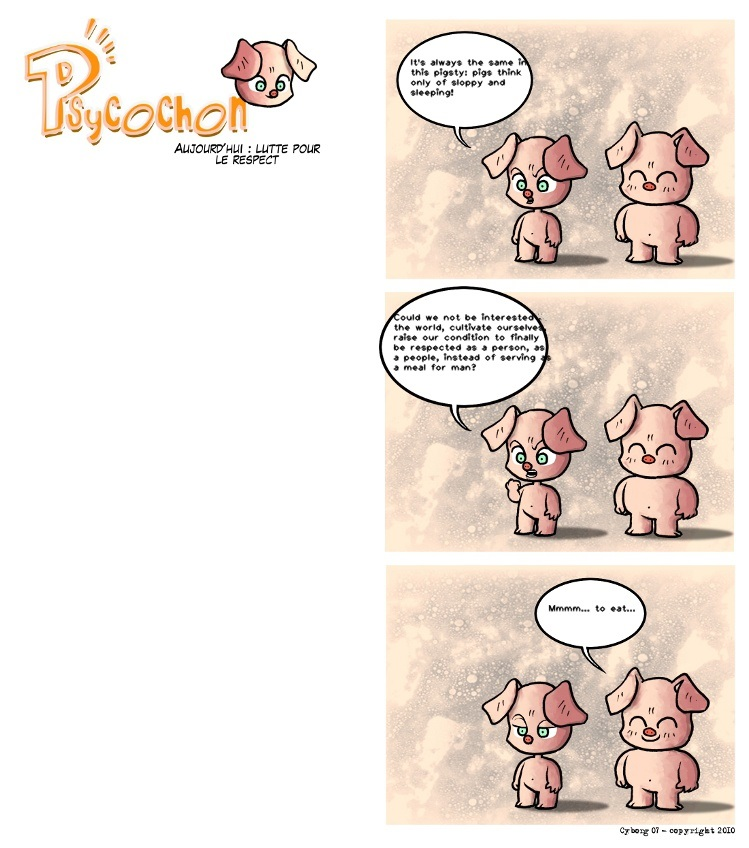